# VBLL Classification

In this notebook, we walk through implementing VBLL classification models, including out of distribution detection.

If you are new to VBLL models, we recommend checking out the regression notebook first!

In [1]:
%cd "C:\Users\mateu\Desktop\uni\phd\bayesian\vbll"

C:\Users\mateu\Desktop\uni\phd\bayesian\vbll


In [2]:
import vbll

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass

from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn import metrics

from tqdm import tqdm
from matplotlib.pyplot import cm

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


We will train a small MLP on MNIST. We use Fashion MNIST as an out of distribution dataset. We will also define a simple visualization function, which we will use later.

In [7]:
data_root = r"C:\Users\mateu\Desktop\uni\phd\data"

In [3]:
mnist_train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

mnist_test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

fashion_train_dataset = datasets.FashionMNIST(root='data',
                                    train=True,
                                    transform=transforms.ToTensor(),
                                    download=True)

fashion_test_dataset = datasets.FashionMNIST(root='data',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=True)

train_dataset = mnist_train_dataset
test_dataset = mnist_test_dataset
ood_dataset = fashion_test_dataset

def dict_to_data(dict):
    if dict.TRAIN == "mnist":
        train =  mnist_train_dataset
    elif dict.TRAIN == "fashion":
        train = fashion_train_dataset
    if dict.TEST == "mnist":
        test =  mnist_test_dataset
    elif dict.TEST == "fashion":
        test = fashion_test_dataset
    if dict.OOD == "mnist":
        ood =  mnist_test_dataset
    elif dict.OOD == "fashion":
        ood = fashion_test_dataset
    return train, test, ood

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3084321.36it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 260580.28it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1870126.24it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3001501.30it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 26421880/26421880 [00:03<00:00, 6635585.05it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 9132109.96it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5874652.26it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2459537.19it/s]


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [8]:
def viz_performance(logs):
  """
  A visualization function that plots losses, accuracies, and out of
  distribution AUROC.

  logs: a dictionary, with keys corresponding to different model evals and values
  corresponding to dicts of results.
  """

  # get list of colors
  color = cm.rainbow(np.linspace(0, 1, len(logs)))

  for i, (k,v) in enumerate(logs.items()):
    # train and val loss
    plt.plot(v['train_loss'], label=k + ' (train)', color=color[i])
    plt.plot(v['val_loss'], label=k + ' (val)', linestyle = '--', color=color[i])
    if 'train_loss_empirical' in v.keys():
      plt.plot(v['train_loss_empirical'], label=k + ' (train empirical)', linestyle = 'dotted', color=color[i])
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

  for i, (k,v) in enumerate(logs.items()):
    plt.plot([1 - x for x in v['train_acc']], label=k + ' (train)', color=color[i])
    plt.plot([1 - x for x in v['val_acc']], label=k + ' (val)', linestyle='--', color=color[i])

  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.legend()
  plt.semilogy()
  plt.show()

  for i, (k,v) in enumerate(logs.items()):
    plt.plot(v['ood_auroc'], label=k, color=color[i])
  plt.legend()
  plt.ylabel('OOD AUROC')
  plt.xlabel('Epoch')
  plt.show()


In [9]:
def aggregate_seeds(d, k):
  vals = np.vstack([v[k] for s,v in d.items()])
  mean_vals, std_vals = np.mean(vals, axis=0), np.std(vals, axis=0)
  return mean_vals, std_vals


def viz_performance_seeds(logs, plot_title=["trained on ... using ...", "ood is ..."]):
  """
  A visualization function that plots losses, accuracies, and out of
  distribution AUROC.

  logs: a dictionary, with keys corresponding to different model evals and values
  corresponding to dicts of results by seed.
  """

  # get list of colors
  color = cm.rainbow(np.linspace(0, 1, len(logs)))

  plt.figure(figsize=(10,6))
  for i, (k,v) in enumerate(logs.items()):
    # train and val loss
    mean_train_loss, std_train_loss = aggregate_seeds(v, 'train_loss')
    mean_val_loss, std_val_loss = aggregate_seeds(v, 'val_loss')
    if 'train_loss_empirical' in list(v.values())[0].keys():
      mean_train_empirical_loss, std_train_empirical_loss = aggregate_seeds(v, 'train_loss_empirical')
      plt.plot(mean_train_empirical_loss, label=k + ' (train empirical)', linestyle = 'dotted', color=color[i])
      plt.fill_between(range(len(mean_train_empirical_loss)), mean_train_empirical_loss-std_train_empirical_loss, mean_train_empirical_loss+std_train_empirical_loss, alpha=0.2, color=color[i])
      #plt.errorbar(range(len(mean_train_empirical_loss)), mean_train_empirical_loss, yerr=std_train_empirical_loss, fmt='none', ecolor=color[i], capsize=7, label='Train empirical (std)')
    plt.plot(mean_train_loss, label=k + ' (train)', color=color[i])
    plt.fill_between(range(len(mean_train_loss)), mean_train_loss-std_train_loss, mean_train_loss+std_train_loss, alpha=0.2, color=color[i])
    #plt.errorbar(range(len(mean_train_loss)), mean_train_loss, yerr=std_train_loss, fmt='none', ecolor=color[i], capsize=7, label='Train (std)')
    plt.plot(mean_val_loss, label=k + ' (val)', linestyle = '--', color=color[i])
    plt.fill_between(range(len(mean_val_loss)), mean_val_loss-std_val_loss, mean_val_loss+std_val_loss, alpha=0.2, color=color[i])
    #plt.errorbar(range(len(mean_val_loss)), mean_val_loss, yerr=std_val_loss, fmt='none', ecolor=color[i], capsize=7, label='Val (std)')
  plt.legend()
  plt.title(plot_title[0] + " - losses")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

  plt.figure(figsize=(10,6))
  for i, (k,v) in enumerate(logs.items()):
    # train and val acc
    mean_train_acc, std_train_acc = aggregate_seeds(v, 'train_acc')
    mean_val_acc, std_val_acc = aggregate_seeds(v, 'val_acc')
    plt.plot([1 - x for x in mean_train_acc], label=k + ' (train)', color=color[i])
    plt.fill_between(range(len(mean_train_acc)), [1 - x - y for x,y in zip(mean_train_acc,std_train_acc)], [1 - x + y for x,y in zip(mean_train_acc,std_train_acc)], alpha=0.2, color=color[i])
    plt.plot([1 - x for x in mean_val_acc], label=k + ' (val)', linestyle='--', color=color[i])
    plt.fill_between(range(len(mean_val_acc)), [1 - x - y for x,y in zip(mean_val_acc,std_val_acc)], [1 - x + y for x,y in zip(mean_val_acc,std_val_acc)], alpha=0.2, color=color[i])

  plt.title(plot_title[0] + " - errors")
  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.legend()
  plt.semilogy()
  plt.show()

  plt.figure(figsize=(10,6))
  for i, (k,v) in enumerate(logs.items()):
    # ood auroc
    mean_ood_auroc, std_ood_auroc = aggregate_seeds(v, 'ood_auroc')
    plt.plot(mean_ood_auroc, label=k, color=color[i])
    plt.fill_between(range(len(mean_ood_auroc)), mean_ood_auroc-std_ood_auroc, mean_ood_auroc+std_ood_auroc, alpha=0.2, color=color[i])
  plt.legend()
  plt.title(plot_title[1])
  plt.ylabel('OOD AUROC')
  plt.xlabel('Epoch')
  plt.show()

We will first define a simple MLP (with a standard last layer) as a baseline.

In [10]:
class MLP(nn.Module):
  """
  A standard MLP classification model.

  cfg: a config containing model parameters.
  """
  def __init__(self, cfg):
    super(MLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': nn.Linear(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return F.log_softmax(self.params['out_layer'](x), dim=-1)

We have defined a model, and can now write a train loop. In our regression notebook, we write a different train loop for the baseline models and for VBLL models, and highlight the differences. Here, our train function takes are argument in train_cfg indicating whether a model has a VBLL last layer or not. There is a handful of if statements in the code that are different for baseline models and for VBLL models, but the differences are relatively small.

In [11]:
def eval_acc(preds, y):
  map_preds = torch.argmax(preds, dim=1)
  return (map_preds == y).float().mean()

def eval_ood(model, ind_dataloader, ood_dataloader, VBLL=True):
  ind_preds = []
  ood_preds = []

  def get_score(out):
    if VBLL:
      score = out.ood_scores.detach().cpu().numpy()
    else:
      score = torch.max(out, dim=-1)[0].detach().cpu().numpy()
    return score

  for i, (x, y) in enumerate(ind_dataloader):
    x = x.to(device)
    out = model(x)
    ind_preds = np.concatenate((ind_preds, get_score(out)))

  for i, (x, y) in enumerate(ood_dataloader):
    x = x.to(device)
    out = model(x)
    ood_preds = np.concatenate((ood_preds, get_score(out)))

  labels = np.concatenate((np.ones_like(ind_preds)+1, np.ones_like(ind_preds)))
  scores = np.concatenate((ind_preds, ood_preds))
  fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=2)
  return metrics.auc(fpr, tpr)

In [14]:
def train(model, train_cfg):
  """Train a standard classification model with either standard or VBLL models.
  """

  train_dataset, test_dataset, ood_dataset = dict_to_data(train_cfg.DATA)

  if train_cfg.VBLL:
    # for VBLL models, set weight decay to zero on last layer
    param_list = [
        {'params': model.params.in_layer.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.core.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.out_layer.parameters(), 'weight_decay': 0.}
    ]
  else:
    param_list = model.parameters()
    loss_fn = nn.CrossEntropyLoss() # define loss function only for non-VBLL model

  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  train_dataloader = DataLoader(train_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(test_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  ood_dataloader = DataLoader(ood_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)

  output_metrics = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': [],
      'ood_auroc': []
  }

  for epoch in range(train_cfg.NUM_EPOCHS):
    model.train()
    running_loss = []
    if train_cfg.VBLL and model.params.out_layer.return_empirical:
      output_metrics['train_loss_empirical'] = []
      running_loss_empirical = []
    running_acc = []

    for train_step, data in enumerate(train_dataloader):
      optimizer.zero_grad()
      x = data[0].to(device)
      y = data[1].to(device)

      out = model(x)
      if train_cfg.VBLL:
        loss = out.train_loss_fn(y)
        if model.params.out_layer.return_empirical:
          loss_empirical = out.train_loss_fn_empirical(y, train_cfg.N_SAMPLES)
          running_loss_empirical.append(loss_empirical.item())
        probs = out.predictive.probs
        acc = eval_acc(probs, y).item()
      else:
        loss = loss_fn(out, y)
        acc = eval_acc(out, y).item()

      running_loss.append(loss.item())
      running_acc.append(acc)

      if train_cfg.VBLL and model.params.out_layer.return_empirical and train_cfg.VBLL_EMPIRICAL and train_cfg.N_SAMPLES:
        loss_empirical.backward()
      else:
        loss.backward()
      optimizer.step()

    output_metrics['train_loss'].append(np.mean(running_loss))
    if train_cfg.VBLL and model.params.out_layer.return_empirical:
      output_metrics['train_loss_empirical'].append(np.mean(running_loss_empirical))
    output_metrics['train_acc'].append(np.mean(running_acc))

    if epoch % train_cfg.VAL_FREQ == 0:
      running_val_loss = []
      running_val_acc = []

      with torch.no_grad():
        model.eval()
        for test_step, data in enumerate(val_dataloader):
          x = data[0].to(device)
          y = data[1].to(device)

          out = model(x)
          if train_cfg.VBLL:
            loss = out.val_loss_fn(y)
            probs = out.predictive.probs
            acc = eval_acc(probs, y).item()
          else:
            loss = loss_fn(out, y)
            acc = eval_acc(out, y).item()

          running_val_loss.append(loss.item())
          running_val_acc.append(acc)

        output_metrics['val_loss'].append(np.mean(running_val_loss))
        output_metrics['val_acc'].append(np.mean(running_val_acc))
      output_metrics['ood_auroc'].append(eval_ood(model, val_dataloader, ood_dataloader, VBLL=train_cfg.VBLL))
      print('Epoch: {:2d}, train loss: {:4.4f}, train acc: {:4.4f}'.format(epoch, np.mean(running_loss), np.mean(running_acc)))
      if train_cfg.VBLL and model.params.out_layer.return_empirical:
        print('Epoch: {:2d}, train loss empirical: {:4.4f}'.format(epoch, np.mean(running_loss_empirical)))
      print('Epoch: {:2d}, valid loss: {:4.4f}, valid acc: {:4.4f}'.format(epoch, np.mean(np.mean(running_val_loss)), np.mean(np.mean(running_val_acc))))
  return output_metrics

In [ ]:
GLOBAL_LR = 1e-3
GLOBAL_NUM_EPOCHS = 30
GLOBAL_OPT = torch.optim.SGD

We can now train a baseline MLP:

In [8]:
outputs = {}

In [15]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 1e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = False

class cfg:
  IN_FEATURES = 784
  HIDDEN_FEATURES = 128
  OUT_FEATURES = 10
  NUM_LAYERS = 2


model = MLP(cfg()).to(device)
tr_c = train_cfg()
outputs[f'MLP opt:{tr_c.OPT.__name__}lr:{tr_c.LR}'] = train(model, tr_c)

Epoch:  0, train loss: 0.5982, train acc: 0.8374
Epoch:  0, valid loss: 0.2625, valid acc: 0.9230
Epoch:  1, train loss: 0.2406, train acc: 0.9287
Epoch:  1, valid loss: 0.2046, valid acc: 0.9392
Epoch:  2, train loss: 0.1950, train acc: 0.9420
Epoch:  2, valid loss: 0.1761, valid acc: 0.9467
Epoch:  3, train loss: 0.1618, train acc: 0.9518
Epoch:  3, valid loss: 0.1566, valid acc: 0.9526
Epoch:  4, train loss: 0.1388, train acc: 0.9575
Epoch:  4, valid loss: 0.1344, valid acc: 0.9579
Epoch:  5, train loss: 0.1215, train acc: 0.9629
Epoch:  5, valid loss: 0.1235, valid acc: 0.9609
Epoch:  6, train loss: 0.1041, train acc: 0.9676
Epoch:  6, valid loss: 0.1121, valid acc: 0.9644
Epoch:  7, train loss: 0.0915, train acc: 0.9718
Epoch:  7, valid loss: 0.1140, valid acc: 0.9641
Epoch:  8, train loss: 0.0826, train acc: 0.9743
Epoch:  8, valid loss: 0.1075, valid acc: 0.9659
Epoch:  9, train loss: 0.0732, train acc: 0.9766
Epoch:  9, valid loss: 0.0926, valid acc: 0.9710
Epoch: 10, train los

In [ ]:
outputs

In [ ]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = GLOBAL_NUM_EPOCHS
  BATCH_SIZE = 512
  LR = GLOBAL_LR
  WD = 1e-4
  OPT = GLOBAL_OPT
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = False

class cfg:
  IN_FEATURES = 784
  HIDDEN_FEATURES = 128
  OUT_FEATURES = 10
  NUM_LAYERS = 2


model = MLP(cfg()).to(device)
tr_c = train_cfg()
outputs[f'MLP opt:{tr_c.OPT.__name__}lr:{tr_c.LR}'] = train(model, tr_c)

In [ ]:
outputs

In [31]:
class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

class train_cfg:
    SEED = 8
    DATA = data_cfg()
    NUM_EPOCHS = GLOBAL_NUM_EPOCHS
    BATCH_SIZE = 512
    LR = GLOBAL_LR
    WD = 1e-4
    OPT = GLOBAL_OPT
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = False

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2

mod_c = cfg()
tr_c = train_cfg()
exp_name = f'MLP-POINT opt:{tr_c.OPT.__name__}lr:{tr_c.LR}'
exp_setup = f'model:{mod_c.NUM_LAYERS}x{mod_c.HIDDEN_FEATURES} data:{tr_c.DATA.TRAIN} ood:{tr_c.DATA.OOD}'
outputs[exp_name] = dict()

SEEDS = [0,1,2]
for s in SEEDS:
    tr_c.SEED = s
    torch.manual_seed(s)
    np.random.seed(s)
    model = MLP(mod_c).to(device)
    outputs[exp_name][s] = train(model, tr_c)

Epoch:  0, train loss: 0.6027, train acc: 0.8378
Epoch:  0, valid loss: 0.2740, valid acc: 0.9178
Epoch:  1, train loss: 0.2543, train acc: 0.9254
Epoch:  1, valid loss: 0.2175, valid acc: 0.9359
Epoch:  2, train loss: 0.2036, train acc: 0.9393
Epoch:  2, valid loss: 0.1855, valid acc: 0.9437
Epoch:  3, train loss: 0.1683, train acc: 0.9501
Epoch:  3, valid loss: 0.1620, valid acc: 0.9505
Epoch:  4, train loss: 0.1403, train acc: 0.9573
Epoch:  4, valid loss: 0.1394, valid acc: 0.9563
Epoch:  5, train loss: 0.1211, train acc: 0.9629
Epoch:  5, valid loss: 0.1270, valid acc: 0.9596
Epoch:  6, train loss: 0.1031, train acc: 0.9684
Epoch:  6, valid loss: 0.1159, valid acc: 0.9637
Epoch:  7, train loss: 0.0917, train acc: 0.9718
Epoch:  7, valid loss: 0.1094, valid acc: 0.9647
Epoch:  8, train loss: 0.0830, train acc: 0.9740
Epoch:  8, valid loss: 0.1006, valid acc: 0.9679
Epoch:  9, train loss: 0.0746, train acc: 0.9771
Epoch:  9, valid loss: 0.0950, valid acc: 0.9697
Epoch: 10, train los

Now, let's define a VBLL model. Note that the only difference is the out_layer switching from a linear layer to a VBLLClassificationD layer.

We also no longer need to include an output softmax, since that is included in the VBLL classification layer.

In [9]:
class DiscVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(DiscVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.DiscClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, softmax_bound=cfg.SOFTMAX_BOUND, return_empirical=cfg.RETURN_EMPIRICAL, softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [17]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True
  VBLL_EMPIRICAL = False
  N_SAMPLES = 10

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs['DiscVBLL'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.0236, train acc: 0.8318
Epoch:  0, train loss empirical: 0.7792
Epoch:  0, valid loss: 0.3031, valid acc: 0.9129
Epoch:  1, train loss: 0.5134, train acc: 0.9221
Epoch:  1, train loss empirical: 0.3570
Epoch:  1, valid loss: 0.2612, valid acc: 0.9231
Epoch:  2, train loss: 0.4056, train acc: 0.9360
Epoch:  2, train loss empirical: 0.2911
Epoch:  2, valid loss: 0.2033, valid acc: 0.9411
Epoch:  3, train loss: 0.3289, train acc: 0.9472
Epoch:  3, train loss empirical: 0.2406
Epoch:  3, valid loss: 0.1829, valid acc: 0.9436
Epoch:  4, train loss: 0.2776, train acc: 0.9572
Epoch:  4, train loss empirical: 0.2059
Epoch:  4, valid loss: 0.1379, valid acc: 0.9613
Epoch:  5, train loss: 0.2453, train acc: 0.9626
Epoch:  5, train loss empirical: 0.1853
Epoch:  5, valid loss: 0.1278, valid acc: 0.9603
Epoch:  6, train loss: 0.2246, train acc: 0.9661
Epoch:  6, train loss empirical: 0.1725
Epoch:  6, valid loss: 0.1390, valid acc: 0.9579
Epoch:  7, train loss: 0.2063, tra

In [32]:
if 'DiscVBLL' not in outputs.keys():
    outputs['DiscVBLL'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

    class data_cfg:
        TRAIN = "mnist"
        TEST = "mnist"
        OOD = "fashion"

    class train_cfg:
        SEED = s
        DATA = data_cfg()
        NUM_EPOCHS = 30
        BATCH_SIZE = 512
        LR = 3e-3
        WD = 1e-4
        OPT = torch.optim.AdamW
        CLIP_VAL = 1
        VAL_FREQ = 1
        VBLL = True
        VBLL_EMPIRICAL = False
        N_SAMPLES = 10

    class cfg:
        IN_FEATURES = 784
        HIDDEN_FEATURES = 128
        OUT_FEATURES = 10
        NUM_LAYERS = 2
        REG_WEIGHT = 1./mnist_train_dataset.__len__()
        PARAM = 'diagonal'
        SOFTMAX_BOUND = "jensen"
        RETURN_EMPIRICAL = True
        SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
        RETURN_OOD = True
        PRIOR_SCALE = 1.

    torch.manual_seed(s)
    np.random.seed(s)
    disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
    outputs['DiscVBLL'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.8271, train acc: 0.8628
Epoch:  0, train loss empirical: 0.6073
Epoch:  0, valid loss: 0.2962, valid acc: 0.9162
Epoch:  1, train loss: 0.4706, train acc: 0.9284
Epoch:  1, train loss empirical: 0.3290
Epoch:  1, valid loss: 0.2113, valid acc: 0.9375
Epoch:  2, train loss: 0.3650, train acc: 0.9439
Epoch:  2, train loss empirical: 0.2609
Epoch:  2, valid loss: 0.1721, valid acc: 0.9515
Epoch:  3, train loss: 0.3094, train acc: 0.9512
Epoch:  3, train loss empirical: 0.2282
Epoch:  3, valid loss: 0.1738, valid acc: 0.9484
Epoch:  4, train loss: 0.2649, train acc: 0.9587
Epoch:  4, train loss empirical: 0.1994
Epoch:  4, valid loss: 0.1589, valid acc: 0.9534
Epoch:  5, train loss: 0.2429, train acc: 0.9629
Epoch:  5, train loss empirical: 0.1882
Epoch:  5, valid loss: 0.1576, valid acc: 0.9516
Epoch:  6, train loss: 0.2275, train acc: 0.9646
Epoch:  6, train loss empirical: 0.1801
Epoch:  6, valid loss: 0.1310, valid acc: 0.9614
Epoch:  7, train loss: 0.2093, tra

Empirical (n_samples 10)

In [18]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True
  VBLL_EMPIRICAL = True
  N_SAMPLES = 10

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.0347, train acc: 0.8636
Epoch:  0, train loss empirical: 0.6221
Epoch:  0, valid loss: 0.2714, valid acc: 0.9230
Epoch:  1, train loss: 0.6779, train acc: 0.9311
Epoch:  1, train loss empirical: 0.3274
Epoch:  1, valid loss: 0.2043, valid acc: 0.9405
Epoch:  2, train loss: 0.6059, train acc: 0.9453
Epoch:  2, train loss empirical: 0.2584
Epoch:  2, valid loss: 0.1585, valid acc: 0.9512
Epoch:  3, train loss: 0.5826, train acc: 0.9560
Epoch:  3, train loss empirical: 0.2182
Epoch:  3, valid loss: 0.1502, valid acc: 0.9574
Epoch:  4, train loss: 0.5978, train acc: 0.9627
Epoch:  4, train loss empirical: 0.1886
Epoch:  4, valid loss: 0.1255, valid acc: 0.9604
Epoch:  5, train loss: 0.6302, train acc: 0.9683
Epoch:  5, train loss empirical: 0.1663
Epoch:  5, valid loss: 0.1166, valid acc: 0.9634
Epoch:  6, train loss: 0.6860, train acc: 0.9712
Epoch:  6, train loss empirical: 0.1565
Epoch:  6, valid loss: 0.1246, valid acc: 0.9641
Epoch:  7, train loss: 0.7583, tra

In [10]:
N_SAMPLES = 10

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.8893, train acc: 0.8668
Epoch:  0, train loss empirical: 0.5824
Epoch:  0, valid loss: 0.2769, valid acc: 0.9212
Epoch:  1, train loss: 0.5755, train acc: 0.9329
Epoch:  1, train loss empirical: 0.3109
Epoch:  1, valid loss: 0.2016, valid acc: 0.9409
Epoch:  2, train loss: 0.5259, train acc: 0.9476
Epoch:  2, train loss empirical: 0.2455
Epoch:  2, valid loss: 0.1609, valid acc: 0.9541
Epoch:  3, train loss: 0.5338, train acc: 0.9551
Epoch:  3, train loss empirical: 0.2176
Epoch:  3, valid loss: 0.1845, valid acc: 0.9483
Epoch:  4, train loss: 0.5443, train acc: 0.9638
Epoch:  4, train loss empirical: 0.1813
Epoch:  4, valid loss: 0.1375, valid acc: 0.9604
Epoch:  5, train loss: 0.5919, train acc: 0.9676
Epoch:  5, train loss empirical: 0.1700
Epoch:  5, valid loss: 0.1418, valid acc: 0.9586
Epoch:  6, train loss: 0.6640, train acc: 0.9674
Epoch:  6, train loss empirical: 0.1687
Epoch:  6, valid loss: 0.1285, valid acc: 0.9645
Epoch:  7, train loss: 0.6935, tra

Empirical (n_samples 20)

In [19]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True
  VBLL_EMPIRICAL = True
  N_SAMPLES = 20

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.7459, train acc: 0.8628
Epoch:  0, train loss empirical: 0.6480
Epoch:  0, valid loss: 0.3185, valid acc: 0.9081
Epoch:  1, train loss: 1.1282, train acc: 0.9309
Epoch:  1, train loss empirical: 0.3363
Epoch:  1, valid loss: 0.1918, valid acc: 0.9423
Epoch:  2, train loss: 0.9541, train acc: 0.9471
Epoch:  2, train loss empirical: 0.2612
Epoch:  2, valid loss: 0.1461, valid acc: 0.9532
Epoch:  3, train loss: 0.8709, train acc: 0.9595
Epoch:  3, train loss empirical: 0.2075
Epoch:  3, valid loss: 0.1425, valid acc: 0.9593
Epoch:  4, train loss: 0.8557, train acc: 0.9641
Epoch:  4, train loss empirical: 0.1869
Epoch:  4, valid loss: 0.1591, valid acc: 0.9543
Epoch:  5, train loss: 0.8751, train acc: 0.9680
Epoch:  5, train loss empirical: 0.1729
Epoch:  5, valid loss: 0.1461, valid acc: 0.9595
Epoch:  6, train loss: 0.9026, train acc: 0.9706
Epoch:  6, train loss empirical: 0.1596
Epoch:  6, valid loss: 0.1108, valid acc: 0.9695
Epoch:  7, train loss: 0.9433, tra

In [ ]:
N_SAMPLES = 20

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

In [20]:
class data_cfg:
  TRAIN = "mnist"
  TEST = "mnist"
  OOD = "fashion"

class train_cfg:
  DATA = data_cfg()
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True
  VBLL_EMPIRICAL = True
  N_SAMPLES = 50

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    SOFTMAX_BOUND = "jensen"
    RETURN_EMPIRICAL = True
    SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.6964, train acc: 0.8692
Epoch:  0, train loss empirical: 0.5571
Epoch:  0, valid loss: 0.2715, valid acc: 0.9211
Epoch:  1, train loss: 0.4415, train acc: 0.9304
Epoch:  1, train loss empirical: 0.3067
Epoch:  1, valid loss: 0.2067, valid acc: 0.9380
Epoch:  2, train loss: 0.4172, train acc: 0.9442
Epoch:  2, train loss empirical: 0.2482
Epoch:  2, valid loss: 0.1996, valid acc: 0.9373
Epoch:  3, train loss: 0.4275, train acc: 0.9554
Epoch:  3, train loss empirical: 0.2076
Epoch:  3, valid loss: 0.1404, valid acc: 0.9596
Epoch:  4, train loss: 0.4647, train acc: 0.9611
Epoch:  4, train loss empirical: 0.1843
Epoch:  4, valid loss: 0.1857, valid acc: 0.9421
Epoch:  5, train loss: 0.5235, train acc: 0.9655
Epoch:  5, train loss empirical: 0.1712
Epoch:  5, valid loss: 0.1451, valid acc: 0.9611
Epoch:  6, train loss: 0.5801, train acc: 0.9695
Epoch:  6, train loss empirical: 0.1575
Epoch:  6, valid loss: 0.1158, valid acc: 0.9661
Epoch:  7, train loss: 0.6334, tra

In [37]:
N_SAMPLES = 50

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.8876, train acc: 0.8675
Epoch:  0, train loss empirical: 0.5813
Epoch:  0, valid loss: 0.2746, valid acc: 0.9216
Epoch:  1, train loss: 0.5748, train acc: 0.9332
Epoch:  1, train loss empirical: 0.3095
Epoch:  1, valid loss: 0.2010, valid acc: 0.9404
Epoch:  2, train loss: 0.5254, train acc: 0.9482
Epoch:  2, train loss empirical: 0.2447
Epoch:  2, valid loss: 0.1606, valid acc: 0.9543
Epoch:  3, train loss: 0.5327, train acc: 0.9548
Epoch:  3, train loss empirical: 0.2173
Epoch:  3, valid loss: 0.1939, valid acc: 0.9449
Epoch:  4, train loss: 0.5449, train acc: 0.9636
Epoch:  4, train loss empirical: 0.1826
Epoch:  4, valid loss: 0.1364, valid acc: 0.9597
Epoch:  5, train loss: 0.5873, train acc: 0.9673
Epoch:  5, train loss empirical: 0.1687
Epoch:  5, valid loss: 0.1447, valid acc: 0.9584
Epoch:  6, train loss: 0.6619, train acc: 0.9680
Epoch:  6, train loss empirical: 0.1676
Epoch:  6, valid loss: 0.1237, valid acc: 0.9653
Epoch:  7, train loss: 0.6891, tra

In [11]:
N_SAMPLES = 100

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.8879, train acc: 0.8670
Epoch:  0, train loss empirical: 0.5818
Epoch:  0, valid loss: 0.2742, valid acc: 0.9210
Epoch:  1, train loss: 0.5759, train acc: 0.9323
Epoch:  1, train loss empirical: 0.3101
Epoch:  1, valid loss: 0.2001, valid acc: 0.9389
Epoch:  2, train loss: 0.5246, train acc: 0.9484
Epoch:  2, train loss empirical: 0.2446
Epoch:  2, valid loss: 0.1610, valid acc: 0.9538
Epoch:  3, train loss: 0.5326, train acc: 0.9549
Epoch:  3, train loss empirical: 0.2173
Epoch:  3, valid loss: 0.1984, valid acc: 0.9432
Epoch:  4, train loss: 0.5456, train acc: 0.9631
Epoch:  4, train loss empirical: 0.1840
Epoch:  4, valid loss: 0.1358, valid acc: 0.9601
Epoch:  5, train loss: 0.5858, train acc: 0.9673
Epoch:  5, train loss empirical: 0.1681
Epoch:  5, valid loss: 0.1456, valid acc: 0.9571
Epoch:  6, train loss: 0.6557, train acc: 0.9694
Epoch:  6, train loss empirical: 0.1636
Epoch:  6, valid loss: 0.1255, valid acc: 0.9653
Epoch:  7, train loss: 0.6901, tra

In [12]:
N_SAMPLES = 1000

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "mnist"
    TEST = "mnist"
    OOD = "fashion"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 0.8879, train acc: 0.8674
Epoch:  0, train loss empirical: 0.5816
Epoch:  0, valid loss: 0.2752, valid acc: 0.9228
Epoch:  1, train loss: 0.5756, train acc: 0.9317
Epoch:  1, train loss empirical: 0.3098
Epoch:  1, valid loss: 0.1998, valid acc: 0.9396
Epoch:  2, train loss: 0.5249, train acc: 0.9482
Epoch:  2, train loss empirical: 0.2448
Epoch:  2, valid loss: 0.1598, valid acc: 0.9543
Epoch:  3, train loss: 0.5310, train acc: 0.9552
Epoch:  3, train loss empirical: 0.2160
Epoch:  3, valid loss: 0.1919, valid acc: 0.9467
Epoch:  4, train loss: 0.5454, train acc: 0.9632
Epoch:  4, train loss empirical: 0.1837
Epoch:  4, valid loss: 0.1375, valid acc: 0.9600
Epoch:  5, train loss: 0.5860, train acc: 0.9675
Epoch:  5, train loss empirical: 0.1683
Epoch:  5, valid loss: 0.1442, valid acc: 0.9590
Epoch:  6, train loss: 0.6568, train acc: 0.9691
Epoch:  6, train loss empirical: 0.1638
Epoch:  6, valid loss: 0.1242, valid acc: 0.9652
Epoch:  7, train loss: 0.6922, tra

RESULTS

In [38]:
outputs

{'MLP': {0: {'train_loss': [0.602704751542059,
    0.2543376843302937,
    0.2036393647224216,
    0.1682964596202818,
    0.14028412659289474,
    0.12114030130649522,
    0.10307458412470454,
    0.0917190808676562,
    0.08302633334898342,
    0.07463771455242472,
    0.06491417243634745,
    0.05972567004925114,
    0.05496948951918442,
    0.048728480998237254,
    0.044402916473731145,
    0.040945875971435994,
    0.035757214115080184,
    0.03254503694410294,
    0.028461064180453955,
    0.026580209934578863,
    0.024672267019306703,
    0.023930401059846253,
    0.020548986728792473,
    0.01770584554790314,
    0.01673230453457494,
    0.014165192132152744,
    0.014286020788427252,
    0.011447880805817321,
    0.013238867652065799,
    0.01300808110953135],
   'val_loss': [0.273967969417572,
    0.21747392565011978,
    0.18554342091083526,
    0.16201661825180053,
    0.13944004140794278,
    0.1270353365689516,
    0.11589390076696873,
    0.10935354828834534,
    0.100

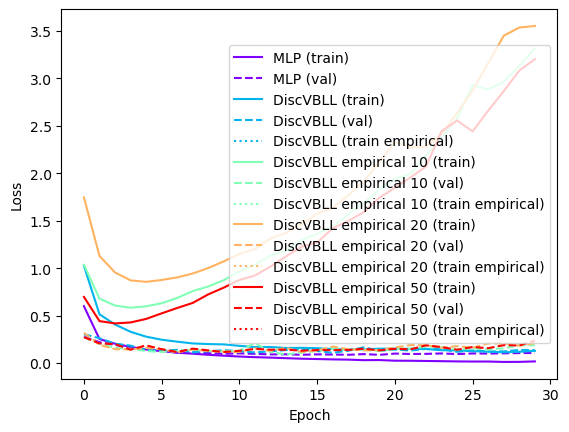

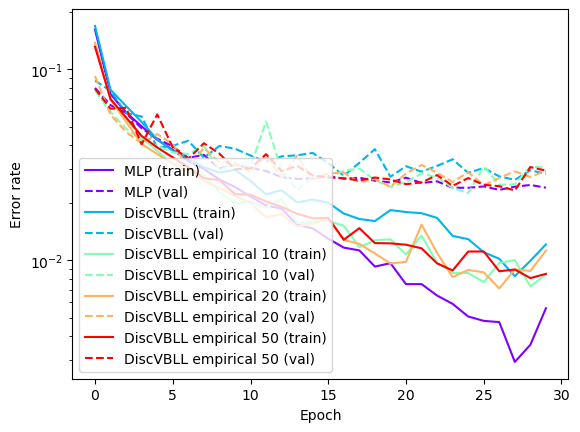

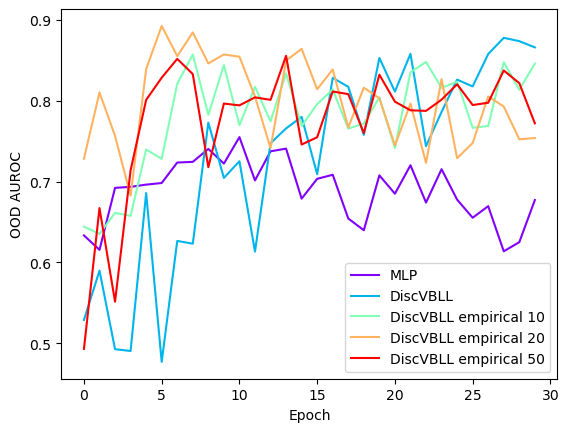

In [29]:
viz_performance(outputs)

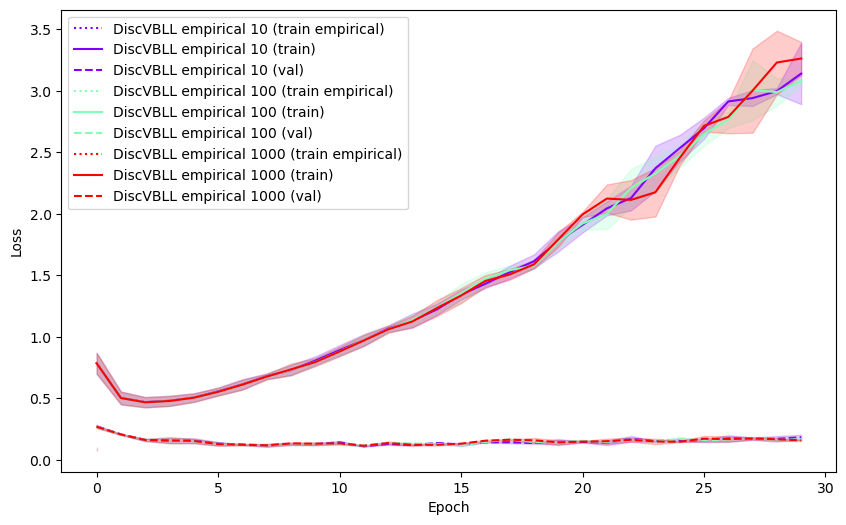

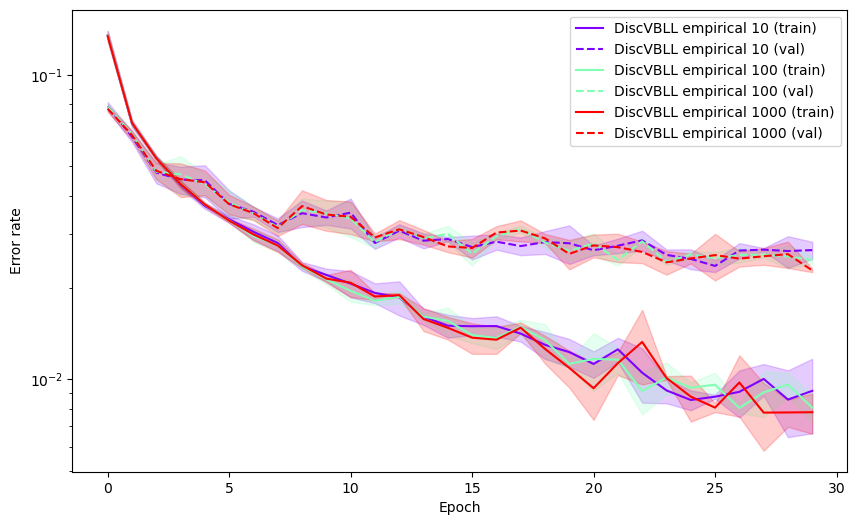

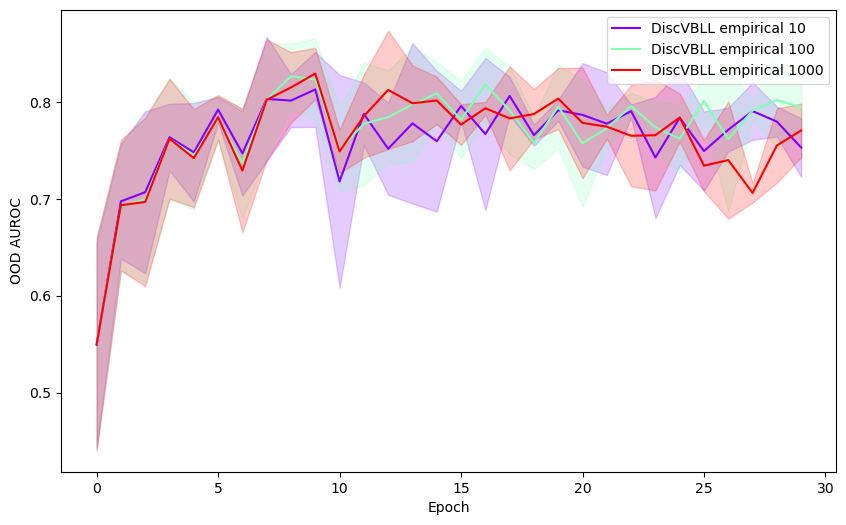

In [14]:
viz_performance_seeds(outputs)

In [13]:
import pickle 

with open('saved_dictionary_10do123.pkl', 'wb') as f:
    pickle.dump(outputs, f)

FASHION, MNIST OOD

In [15]:
outputs = {}

In [60]:
if 'MLP' not in outputs.keys():
    outputs['MLP'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

    class data_cfg:
        TRAIN = "fashion"
        TEST = "fashion"
        OOD = "mnist"

    class train_cfg:
        SEED = s
        DATA = data_cfg()
        NUM_EPOCHS = 30
        BATCH_SIZE = 512
        LR = 1e-3
        WD = 1e-4
        OPT = torch.optim.AdamW
        CLIP_VAL = 1
        VAL_FREQ = 1
        VBLL = False

    class cfg:
        IN_FEATURES = 784
        HIDDEN_FEATURES = 128
        OUT_FEATURES = 10
        NUM_LAYERS = 2

    torch.manual_seed(s)
    np.random.seed(s)
    model = MLP(cfg()).to(device)
    outputs['MLP'][s] = train(model, train_cfg())

Epoch:  0, train loss: 0.7390, train acc: 0.7433
Epoch:  0, valid loss: 0.5347, valid acc: 0.8029
Epoch:  1, train loss: 0.4552, train acc: 0.8371
Epoch:  1, valid loss: 0.4688, valid acc: 0.8269
Epoch:  2, train loss: 0.4161, train acc: 0.8512
Epoch:  2, valid loss: 0.4396, valid acc: 0.8387
Epoch:  3, train loss: 0.3874, train acc: 0.8617
Epoch:  3, valid loss: 0.4208, valid acc: 0.8487
Epoch:  4, train loss: 0.3725, train acc: 0.8654
Epoch:  4, valid loss: 0.4269, valid acc: 0.8428
Epoch:  5, train loss: 0.3635, train acc: 0.8678
Epoch:  5, valid loss: 0.3964, valid acc: 0.8603
Epoch:  6, train loss: 0.3462, train acc: 0.8739
Epoch:  6, valid loss: 0.3940, valid acc: 0.8573
Epoch:  7, train loss: 0.3452, train acc: 0.8724
Epoch:  7, valid loss: 0.3810, valid acc: 0.8624
Epoch:  8, train loss: 0.3299, train acc: 0.8790
Epoch:  8, valid loss: 0.3714, valid acc: 0.8643
Epoch:  9, train loss: 0.3232, train acc: 0.8812
Epoch:  9, valid loss: 0.3757, valid acc: 0.8658
Epoch: 10, train los

In [61]:
if 'DiscVBLL' not in outputs.keys():
    outputs['DiscVBLL'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

    class data_cfg:
        TRAIN = "fashion"
        TEST = "fashion"
        OOD = "mnist"

    class train_cfg:
        SEED = s
        DATA = data_cfg()
        NUM_EPOCHS = 30
        BATCH_SIZE = 512
        LR = 3e-3
        WD = 1e-4
        OPT = torch.optim.AdamW
        CLIP_VAL = 1
        VAL_FREQ = 1
        VBLL = True
        VBLL_EMPIRICAL = False
        N_SAMPLES = 10

    class cfg:
        IN_FEATURES = 784
        HIDDEN_FEATURES = 128
        OUT_FEATURES = 10
        NUM_LAYERS = 2
        REG_WEIGHT = 1./mnist_train_dataset.__len__()
        PARAM = 'diagonal'
        SOFTMAX_BOUND = "jensen"
        RETURN_EMPIRICAL = True
        SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
        RETURN_OOD = True
        PRIOR_SCALE = 1.

    torch.manual_seed(s)
    np.random.seed(s)
    disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
    outputs['DiscVBLL'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.4284, train acc: 0.7416
Epoch:  0, train loss empirical: 1.1818
Epoch:  0, valid loss: 0.5100, valid acc: 0.8191
Epoch:  1, train loss: 0.6835, train acc: 0.8358
Epoch:  1, train loss empirical: 0.5490
Epoch:  1, valid loss: 0.4916, valid acc: 0.8256
Epoch:  2, train loss: 0.6003, train acc: 0.8463
Epoch:  2, train loss empirical: 0.5060
Epoch:  2, valid loss: 0.4994, valid acc: 0.8271
Epoch:  3, train loss: 0.5538, train acc: 0.8510
Epoch:  3, train loss empirical: 0.4826
Epoch:  3, valid loss: 0.4332, valid acc: 0.8477
Epoch:  4, train loss: 0.5090, train acc: 0.8612
Epoch:  4, train loss empirical: 0.4517
Epoch:  4, valid loss: 0.4504, valid acc: 0.8448
Epoch:  5, train loss: 0.4903, train acc: 0.8633
Epoch:  5, train loss empirical: 0.4416
Epoch:  5, valid loss: 0.4183, valid acc: 0.8507
Epoch:  6, train loss: 0.4637, train acc: 0.8697
Epoch:  6, train loss empirical: 0.4225
Epoch:  6, valid loss: 0.4435, valid acc: 0.8430
Epoch:  7, train loss: 0.4576, tra

In [16]:
N_SAMPLES = 10

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "fashion"
    TEST = "fashion"
    OOD = "mnist"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.4519, train acc: 0.7501
Epoch:  0, train loss empirical: 1.0863
Epoch:  0, valid loss: 0.5076, valid acc: 0.8229
Epoch:  1, train loss: 0.7692, train acc: 0.8350
Epoch:  1, train loss empirical: 0.5534
Epoch:  1, valid loss: 0.4764, valid acc: 0.8356
Epoch:  2, train loss: 0.6738, train acc: 0.8519
Epoch:  2, train loss empirical: 0.4957
Epoch:  2, valid loss: 0.5326, valid acc: 0.8219
Epoch:  3, train loss: 0.6323, train acc: 0.8529
Epoch:  3, train loss empirical: 0.4713
Epoch:  3, valid loss: 0.4387, valid acc: 0.8474
Epoch:  4, train loss: 0.6002, train acc: 0.8643
Epoch:  4, train loss empirical: 0.4419
Epoch:  4, valid loss: 0.4671, valid acc: 0.8384
Epoch:  5, train loss: 0.5957, train acc: 0.8652
Epoch:  5, train loss empirical: 0.4335
Epoch:  5, valid loss: 0.4125, valid acc: 0.8506
Epoch:  6, train loss: 0.5830, train acc: 0.8716
Epoch:  6, train loss empirical: 0.4158
Epoch:  6, valid loss: 0.4310, valid acc: 0.8489
Epoch:  7, train loss: 0.5873, tra

In [63]:
N_SAMPLES = 50

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "fashion"
    TEST = "fashion"
    OOD = "mnist"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.4543, train acc: 0.7479
Epoch:  0, train loss empirical: 1.0936
Epoch:  0, valid loss: 0.5124, valid acc: 0.8199
Epoch:  1, train loss: 0.7705, train acc: 0.8357
Epoch:  1, train loss empirical: 0.5549
Epoch:  1, valid loss: 0.4667, valid acc: 0.8386
Epoch:  2, train loss: 0.6751, train acc: 0.8509
Epoch:  2, train loss empirical: 0.4978
Epoch:  2, valid loss: 0.5232, valid acc: 0.8207
Epoch:  3, train loss: 0.6342, train acc: 0.8538
Epoch:  3, train loss empirical: 0.4731
Epoch:  3, valid loss: 0.4270, valid acc: 0.8494
Epoch:  4, train loss: 0.5993, train acc: 0.8632
Epoch:  4, train loss empirical: 0.4412
Epoch:  4, valid loss: 0.4584, valid acc: 0.8412
Epoch:  5, train loss: 0.5935, train acc: 0.8662
Epoch:  5, train loss empirical: 0.4332
Epoch:  5, valid loss: 0.4110, valid acc: 0.8533
Epoch:  6, train loss: 0.5804, train acc: 0.8721
Epoch:  6, train loss empirical: 0.4145
Epoch:  6, valid loss: 0.4278, valid acc: 0.8490
Epoch:  7, train loss: 0.5887, tra

In [17]:
N_SAMPLES = 100

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "fashion"
    TEST = "fashion"
    OOD = "mnist"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.4687, train acc: 0.7469
Epoch:  0, train loss empirical: 1.1072
Epoch:  0, valid loss: 0.5117, valid acc: 0.8153
Epoch:  1, train loss: 0.7659, train acc: 0.8363
Epoch:  1, train loss empirical: 0.5507
Epoch:  1, valid loss: 0.4720, valid acc: 0.8310
Epoch:  2, train loss: 0.6770, train acc: 0.8502
Epoch:  2, train loss empirical: 0.4994
Epoch:  2, valid loss: 0.5044, valid acc: 0.8274
Epoch:  3, train loss: 0.6340, train acc: 0.8535
Epoch:  3, train loss empirical: 0.4736
Epoch:  3, valid loss: 0.4275, valid acc: 0.8519
Epoch:  4, train loss: 0.6017, train acc: 0.8632
Epoch:  4, train loss empirical: 0.4435
Epoch:  4, valid loss: 0.4705, valid acc: 0.8380
Epoch:  5, train loss: 0.5924, train acc: 0.8676
Epoch:  5, train loss empirical: 0.4324
Epoch:  5, valid loss: 0.4177, valid acc: 0.8513
Epoch:  6, train loss: 0.5798, train acc: 0.8715
Epoch:  6, train loss empirical: 0.4146
Epoch:  6, valid loss: 0.4219, valid acc: 0.8495
Epoch:  7, train loss: 0.5840, tra

In [18]:
N_SAMPLES = 1000

if f'DiscVBLL empirical {N_SAMPLES}' not in outputs.keys():
    outputs[f'DiscVBLL empirical {N_SAMPLES}'] = dict()

SEEDS = [0,1,2]
for s in SEEDS:

  class data_cfg:
    TRAIN = "fashion"
    TEST = "fashion"
    OOD = "mnist"

  class train_cfg:
    DATA = data_cfg()
    NUM_EPOCHS = 30
    BATCH_SIZE = 512
    LR = 3e-3
    WD = 1e-4
    OPT = torch.optim.AdamW
    CLIP_VAL = 1
    VAL_FREQ = 1
    VBLL = True
    VBLL_EMPIRICAL = True
    N_SAMPLES = N_SAMPLES

  class cfg:
      IN_FEATURES = 784
      HIDDEN_FEATURES = 128
      OUT_FEATURES = 10
      NUM_LAYERS = 2
      REG_WEIGHT = 1./mnist_train_dataset.__len__()
      PARAM = 'diagonal'
      SOFTMAX_BOUND = "jensen"
      RETURN_EMPIRICAL = True
      SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
      RETURN_OOD = True
      PRIOR_SCALE = 1.

  torch.manual_seed(s)
  np.random.seed(s)

  disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
  outputs[f'DiscVBLL empirical {train_cfg.N_SAMPLES}'][s] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 1.4638, train acc: 0.7459
Epoch:  0, train loss empirical: 1.1019
Epoch:  0, valid loss: 0.4794, valid acc: 0.8308
Epoch:  1, train loss: 0.7704, train acc: 0.8358
Epoch:  1, train loss empirical: 0.5550
Epoch:  1, valid loss: 0.4669, valid acc: 0.8371
Epoch:  2, train loss: 0.6730, train acc: 0.8520
Epoch:  2, train loss empirical: 0.4960
Epoch:  2, valid loss: 0.5097, valid acc: 0.8263
Epoch:  3, train loss: 0.6347, train acc: 0.8542
Epoch:  3, train loss empirical: 0.4738
Epoch:  3, valid loss: 0.4225, valid acc: 0.8516
Epoch:  4, train loss: 0.6011, train acc: 0.8636
Epoch:  4, train loss empirical: 0.4428
Epoch:  4, valid loss: 0.4658, valid acc: 0.8401
Epoch:  5, train loss: 0.5916, train acc: 0.8664
Epoch:  5, train loss empirical: 0.4318
Epoch:  5, valid loss: 0.4152, valid acc: 0.8507
Epoch:  6, train loss: 0.5809, train acc: 0.8721
Epoch:  6, train loss empirical: 0.4154
Epoch:  6, valid loss: 0.4235, valid acc: 0.8497
Epoch:  7, train loss: 0.5859, tra

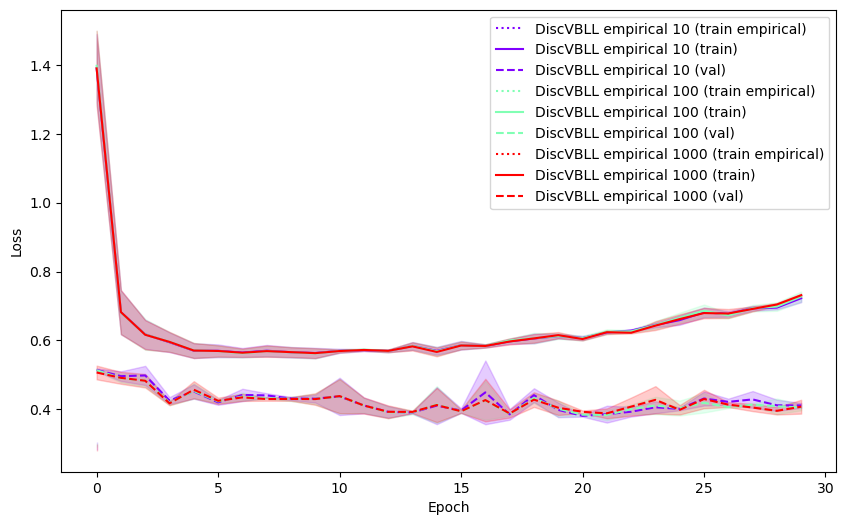

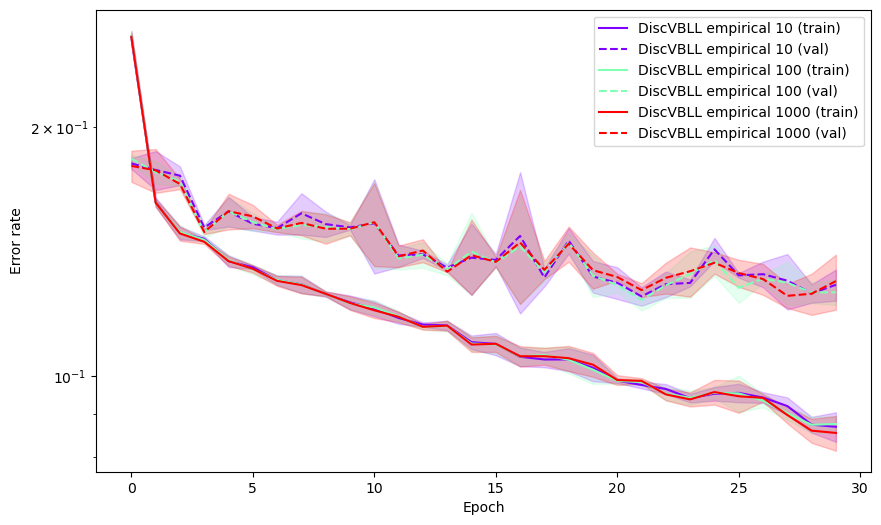

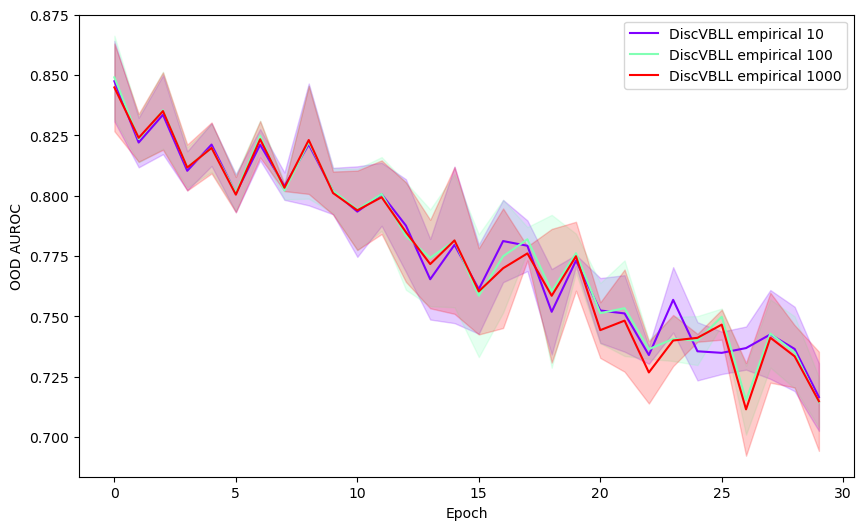

In [19]:
viz_performance_seeds(outputs)

In [20]:
import pickle 

with open('saved_dictionary_fashion_10do123.pkl', 'wb') as f:
    pickle.dump(outputs, f)

We can also train a VBLL MLP with a Generative VBLL last layer. Note that we are only changing the output layer. We can use the same config.

Note also that the train loss is not directly comparable between the generative and discriminative models.

In [ ]:
class GenVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(GenVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.GenClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [ ]:
gen_vbll_model = GenVBLLMLP(cfg()).to(device)
outputs['GenVBLL'] = train(gen_vbll_model, train_cfg())

Epoch:  0, train loss: 1052.9993
Epoch:  0, valid loss: 1.0089
Epoch:  1, train loss: 411.9979
Epoch:  1, valid loss: 0.4640
Epoch:  2, train loss: 224.6902
Epoch:  2, valid loss: 0.3177
Epoch:  3, train loss: 143.0866
Epoch:  3, valid loss: 0.2567
Epoch:  4, train loss: 99.4332
Epoch:  4, valid loss: 0.2219
Epoch:  5, train loss: 73.2394
Epoch:  5, valid loss: 0.1944
Epoch:  6, train loss: 56.1805
Epoch:  6, valid loss: 0.1693
Epoch:  7, train loss: 44.3615
Epoch:  7, valid loss: 0.1641
Epoch:  8, train loss: 35.9223
Epoch:  8, valid loss: 0.1493
Epoch:  9, train loss: 29.5990
Epoch:  9, valid loss: 0.1312
Epoch: 10, train loss: 24.7483
Epoch: 10, valid loss: 0.1246
Epoch: 11, train loss: 20.9903
Epoch: 11, valid loss: 0.1157
Epoch: 12, train loss: 17.9761
Epoch: 12, valid loss: 0.1115
Epoch: 13, train loss: 15.5314
Epoch: 13, valid loss: 0.1111
Epoch: 14, train loss: 13.5226
Epoch: 14, valid loss: 0.1042
Epoch: 15, train loss: 11.8618
Epoch: 15, valid loss: 0.0962
Epoch: 16, train lo

And finally, we can visualize performance of all models.

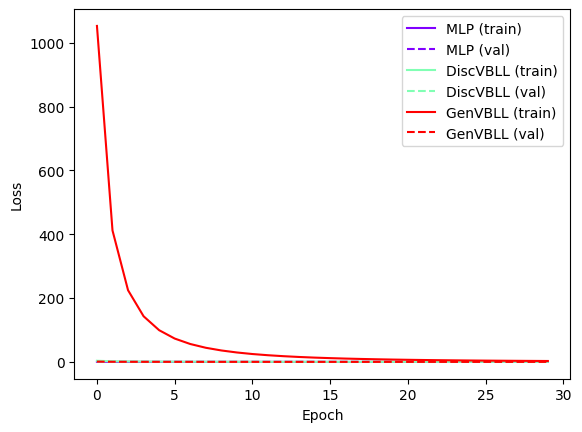

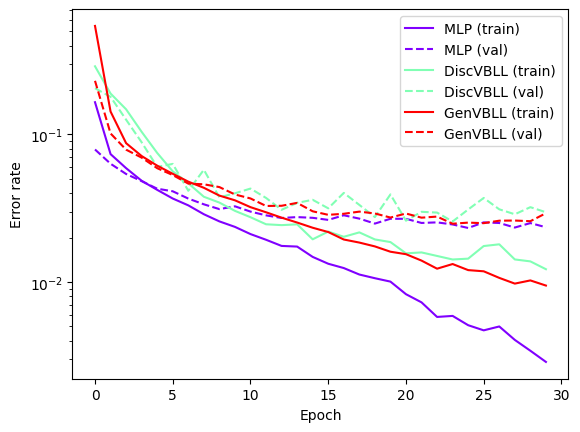

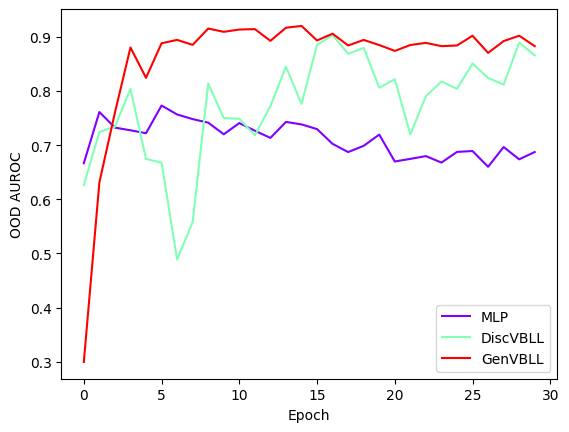

In [ ]:
viz_performance(outputs)